# Diffusion Maps based Generative Modelling on MNIST

This notebook implements a simple diffusion-maps–based generative model for static
MNIST digits.

**Pipeline:**

1. Load MNIST and normalize images.
2. Train an autoencoder (either MLP-based or CNN-based) to learn a low-dimensional latent space.
3. Map training images to latent codes.
4. Apply Diffusion Maps on latent codes to obtain diffusion coordinates.
5. Fit a multivariate Gaussian in diffusion space and sample new diffusion points.
6. Reconstruct latent vectors for new points via k-NN interpolation in diffusion space.
7. Decode latent vectors back to images and visually inspect generated digits.


In [ ]:
# Configure core libraries, plotting defaults, and compute device
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from scipy.sparse.linalg import eigs

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

np.random.seed(42)
torch.manual_seed(42)

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["figure.dpi"] = 120

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
# Load MNIST datasets and build training/test data loaders
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),  # [0, 1]
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Train size:", len(train_dataset), "Test size:", len(test_dataset))


Train size: 60000 Test size: 10000


In [ ]:
# Define the fully connected autoencoder blocks used for the MLP baseline
latent_dim = 8  # dimension of the latent space

class MLPEncoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
        )

    def forward(self, x):
        return self.net(x)


class MLPDecoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid(),
        )

    def forward(self, z):
        x_flat = self.net(z)
        return x_flat.view(-1, 1, 28, 28)


class MLPAutoencoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.encoder = MLPEncoder(latent_dim)
        self.decoder = MLPDecoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z


In [ ]:
# Define the convolutional autoencoder architecture for improved spatial modeling
class CNNEncoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 1x28x28 -> 16x14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # 16x14x14 -> 32x7x7
            nn.ReLU(),
        )
        self.fc = nn.Linear(32 * 7 * 7, latent_dim)

    def forward(self, x):
        h = self.conv(x)
        h = h.view(h.size(0), -1)
        z = self.fc(h)
        return z


class CNNDecoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 32 * 7 * 7)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(
                32, 16, kernel_size=3, stride=2, padding=1, output_padding=1
            ),  # 32x7x7 -> 16x14x14
            nn.ReLU(),
            nn.ConvTranspose2d(
                16, 1, kernel_size=3, stride=2, padding=1, output_padding=1
            ),  # 16x14x14 -> 1x28x28
            nn.Sigmoid(),
        )

    def forward(self, z):
        h = self.fc(z)
        h = h.view(-1, 32, 7, 7)
        x = self.deconv(h)
        return x


class CNNAutoencoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.encoder = CNNEncoder(latent_dim)
        self.decoder = CNNDecoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z


In [ ]:
# Choose which autoencoder variant to train and move it to the target device
# Option 1: MLP autoencoder
# autoencoder = MLPAutoencoder(latent_dim=latent_dim).to(device)

# Option 2: CNN autoencoder (default here)
autoencoder = CNNAutoencoder(latent_dim=latent_dim).to(device)

print(autoencoder)


CNNAutoencoder(
  (encoder): CNNEncoder(
    (conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
    )
    (fc): Linear(in_features=1568, out_features=8, bias=True)
  )
  (decoder): CNNDecoder(
    (fc): Linear(in_features=8, out_features=1568, bias=True)
    (deconv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (3): Sigmoid()
    )
  )
)


In [ ]:
# Train the selected autoencoder on MNIST with Adam and report epoch losses
num_epochs = 10
learning_rate = 1e-3

criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

autoencoder.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)

        optimizer.zero_grad()
        recon, z = autoencoder(images)
        loss = criterion(recon, images)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 0.0564
Epoch [2/10], Loss: 0.0309
Epoch [2/10], Loss: 0.0309
Epoch [3/10], Loss: 0.0270
Epoch [3/10], Loss: 0.0270
Epoch [4/10], Loss: 0.0251
Epoch [4/10], Loss: 0.0251
Epoch [5/10], Loss: 0.0241
Epoch [5/10], Loss: 0.0241
Epoch [6/10], Loss: 0.0233
Epoch [6/10], Loss: 0.0233
Epoch [7/10], Loss: 0.0228
Epoch [7/10], Loss: 0.0228
Epoch [8/10], Loss: 0.0223
Epoch [8/10], Loss: 0.0223
Epoch [9/10], Loss: 0.0219
Epoch [9/10], Loss: 0.0219
Epoch [10/10], Loss: 0.0216
Epoch [10/10], Loss: 0.0216


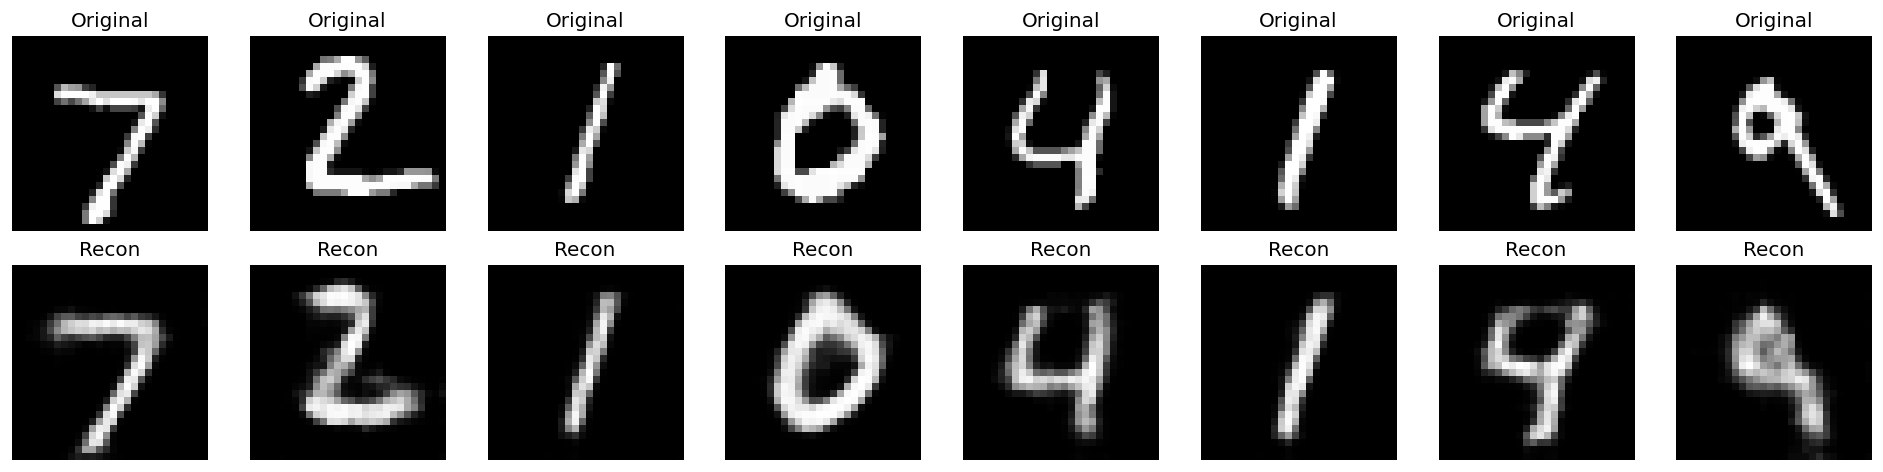

In [ ]:
# Visualize a batch of original vs reconstructed digits to sanity-check training
autoencoder.eval()
images, labels = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    recon, _ = autoencoder(images)

images_cpu = images.cpu().numpy()
recon_cpu = recon.cpu().numpy()

n_show = 8
fig, axes = plt.subplots(2, n_show, figsize=(2 * n_show, 4))
for i in range(n_show):
    axes[0, i].imshow(images_cpu[i, 0], cmap="gray")
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")
    axes[1, i].imshow(recon_cpu[i, 0], cmap="gray")
    axes[1, i].axis("off")
    axes[1, i].set_title("Recon")
plt.tight_layout()
plt.show()


In [ ]:
# Encode the full training set to collect latent vectors and labels for DM
autoencoder.eval()

all_latents = []
all_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        _, z = autoencoder(images)
        all_latents.append(z.cpu().numpy())
        all_labels.append(labels.numpy())

Z = np.concatenate(all_latents, axis=0)   # shape (N, latent_dim)
y_labels = np.concatenate(all_labels, axis=0)

print("Latent codes shape:", Z.shape)


Latent codes shape: (60000, 8)


In [ ]:
# Prepare the latent sample subset and kernel matrix required for diffusion maps
# Subsample for Diffusion Maps (e.g., 5000 points)
max_dm_samples = 5000
N_total = Z.shape[0]

if N_total > max_dm_samples:
    idx_dm = np.random.choice(N_total, max_dm_samples, replace=False)
else:
    idx_dm = np.arange(N_total)

Z_dm = Z[idx_dm]
labels_dm = y_labels[idx_dm]

print("Latent points used for DM:", Z_dm.shape)

# Pairwise distances
dists = pairwise_distances(Z_dm, metric="euclidean")

# Epsilon via median heuristic
med_sq = np.median(dists**2)
eps = med_sq / (2.0 * np.log(Z_dm.shape[0]))
print("Chosen epsilon:", eps)

# Gaussian kernel
K = np.exp(-dists**2 / (2.0 * eps))

# Row-normalize -> Markov matrix P
row_sums = K.sum(axis=1, keepdims=True)
P = K / row_sums


Latent points used for DM: (5000, 8)
Chosen epsilon: 77.78616270655019
Chosen epsilon: 77.78616270655019


In [ ]:
# Compute the leading diffusion-map eigenpairs to obtain coordinates and spectra
m = 15  # number of eigenvectors

vals, vecs = eigs(P.T, k=m, which="LR")

idx_sort = np.argsort(-np.abs(vals))
vals = vals[idx_sort]
vecs = vecs[:, idx_sort]

lam = np.real(vals)
phi = np.real(vecs)

print("Leading eigenvalues:", lam)


Leading eigenvalues: [1.         0.91229265 0.849356   0.84888811 0.82986425 0.74233435
 0.73432885 0.68813552 0.65239346 0.62020513 0.60937317 0.57459852
 0.54032791 0.52671165 0.51152727]


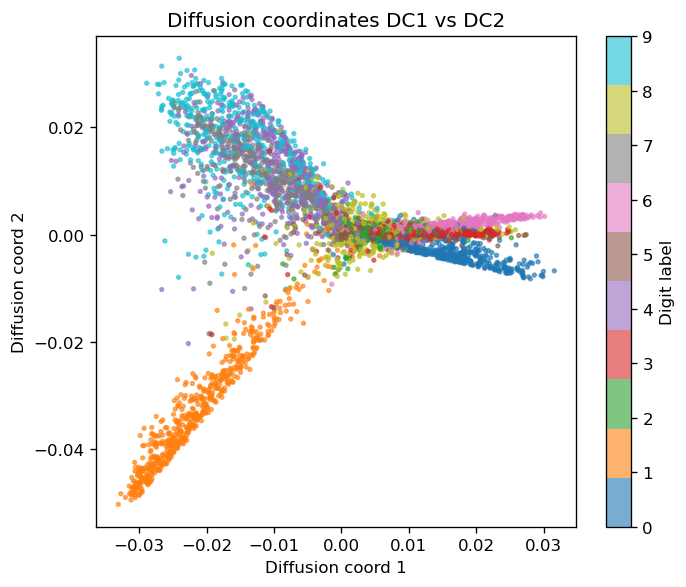

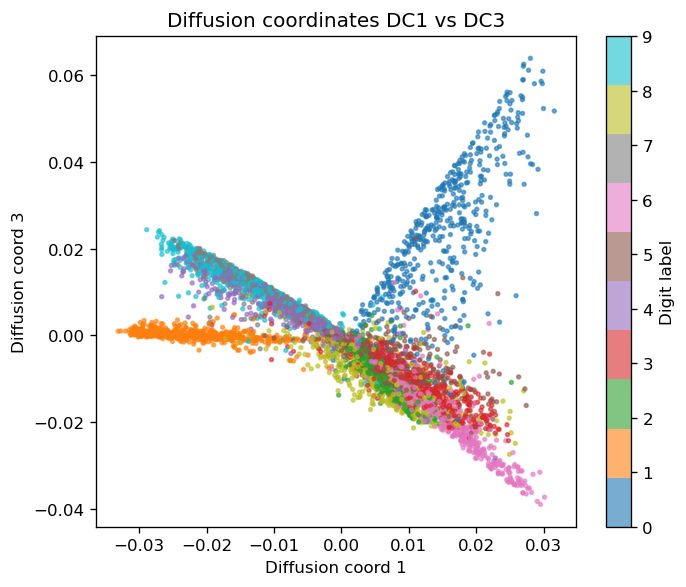

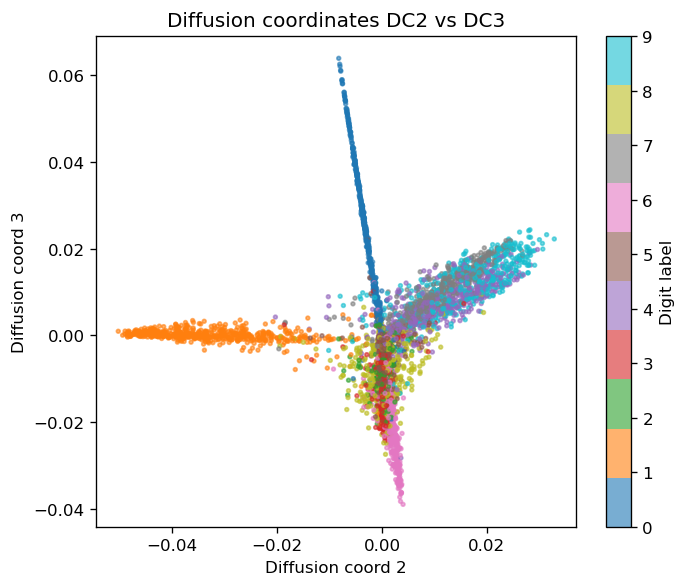

In [ ]:
# Plot several diffusion-coordinate pairs to inspect class separation visually
pairs = [(1, 2), (1, 3), (2, 3)]
for i, j in pairs:
    dc_i = phi[:, i]
    dc_j = phi[:, j]

    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(dc_i, dc_j, c=labels_dm, s=5, alpha=0.6, cmap="tab10")
    plt.xlabel(f"Diffusion coord {i}")
    plt.ylabel(f"Diffusion coord {j}")
    plt.title(f"Diffusion coordinates DC{i} vs DC{j}")
    plt.colorbar(scatter, label="Digit label")
    plt.tight_layout()
    plt.show()


In [ ]:
# Compute diffusion-space mean and covariance for Gaussian modeling
num_dc = 8  # number of nontrivial diffusion coords to use (<= m-1)
Y_dm = phi[:, 1:1 + num_dc]
print("Diffusion-space data shape:", Y_dm.shape)

mu_Y = np.mean(Y_dm, axis=0)
cov_Y = np.cov(Y_dm.T)

print("Mean in diffusion space:", mu_Y)
print("Covariance shape:", cov_Y.shape)


Diffusion-space data shape: (5000, 8)
Mean in diffusion space: [-1.98951966e-17  1.67754699e-17  2.82440737e-17 -1.32893696e-17
  6.05071548e-18  1.76414439e-17 -2.22044605e-19 -1.64313008e-18]
Covariance shape: (8, 8)


In [ ]:
# Sample new diffusion-space points from the fitted Gaussian model
def sample_diffusion_gaussian(n_samples, mu, cov):
    return np.random.multivariate_normal(mean=mu, cov=cov, size=n_samples)

n_gen = 32
Y_new = sample_diffusion_gaussian(n_gen, mu_Y, cov_Y)
print("Generated diffusion points shape:", Y_new.shape)


Generated diffusion points shape: (32, 8)


In [ ]:
# Reconstruct latent vectors for each sampled diffusion point via k-NN interpolation
k_neighbors = 10
nn_model = NearestNeighbors(n_neighbors=k_neighbors, algorithm="auto")
nn_model.fit(Y_dm)

Z_dm_latent = Z_dm  # original latent vectors for DM subset

def reconstruct_latent_from_diffusion_point(y_new, Y_train, Z_train, nn_model, k=10):
    distances, indices = nn_model.kneighbors(y_new.reshape(1, -1), n_neighbors=k)
    distances = distances.flatten()
    indices = indices.flatten()

    sigma = np.median(distances) if np.median(distances) > 0 else 1.0
    weights = np.exp(-distances**2 / (2.0 * sigma**2))
    weights /= weights.sum()

    z_neighbors = Z_train[indices]
    z_new = np.dot(weights, z_neighbors)
    return z_new

Z_new = []
for i in range(n_gen):
    z_new = reconstruct_latent_from_diffusion_point(
        Y_new[i], Y_dm, Z_dm_latent, nn_model, k=k_neighbors
    )
    Z_new.append(z_new)

Z_new = np.array(Z_new)
print("Reconstructed latent samples shape:", Z_new.shape)


Reconstructed latent samples shape: (32, 8)


In [ ]:
# Decode the interpolated latent vectors back into image space
autoencoder.eval()
Z_new_tensor = torch.from_numpy(Z_new).float().to(device)

with torch.no_grad():
    gen_images = autoencoder.decoder(Z_new_tensor)

gen_images_cpu = gen_images.cpu().numpy()
print("Generated images shape:", gen_images_cpu.shape)


Generated images shape: (32, 1, 28, 28)


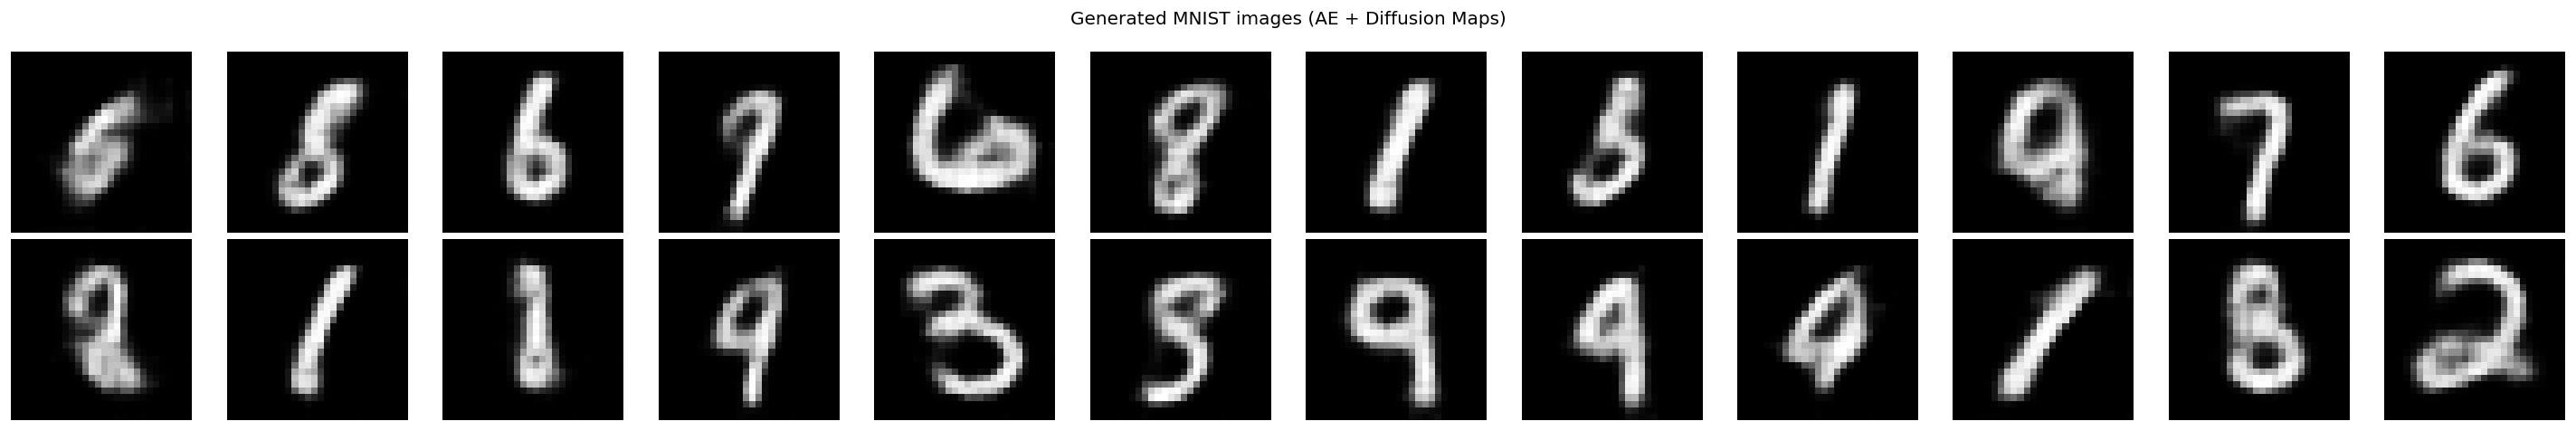

In [ ]:
# Display a grid of generated digits produced by the diffusion-map pipeline
n_show = 24
fig, axes = plt.subplots(2, n_show // 2, figsize=(2 * (n_show // 2), 4))

for i in range(n_show):
    ax = axes[i // (n_show // 2), i % (n_show // 2)]
    ax.imshow(gen_images_cpu[i, 0], cmap="gray")
    ax.axis("off")

plt.suptitle("Generated MNIST images (AE + Diffusion Maps)")
plt.tight_layout()
plt.show()
